## Setup

In [39]:
import os
import configparser

import geopandas as gpd
import h3

from shapely.geometry import Point, Polygon
import pandas as pbd

import matplotlib.pyplot as plt

In [5]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

## Load data

### Load shapefiles

Convert multipolygon to polygon first. Code from [this post](https://staedi.github.io/posts/multipolygon)

In [32]:
import json
filename = os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson')
target_len = 15
 
js = open(filename, 'r').read()
gj = json.loads(js)
output = {"type":"FeatureCollection","features":[]}
 
def process_geojson(filename):
    js = open(filename, 'r').read()
    gj = json.loads(js)
    output = {"type":"FeatureCollection","features":[]}
 
    for feature in gj['features']:
        if feature['geometry'] is not None:
            if feature['geometry']['type'] == 'MultiPolygon':
                len_list = sorted([[idx, len(elem[0])] for idx, elem in enumerate(feature['geometry']['coordinates'])],key=lambda x: x[1],reverse=True)[:target_len]
                reg_len = [i[0] for i in len_list]
 
                for idx, poly in enumerate(feature['geometry']['coordinates']):
                    if len(feature['geometry']['coordinates'])<target_len or idx in reg_len:
                        xfeature = {"type":"Feature", "properties":feature["properties"], "geometry":{"type":"Polygon"}}
                        xfeature['geometry']['coordinates'] = poly
                        output['features'].append(xfeature)
            else:
                for idx, poly in enumerate(feature['geometry']['coordinates']):
                    xfeature = {"type":"Feature", "properties":feature["properties"], "geometry":feature["geometry"]}
                    output['features'].append(xfeature)
 
    open(filename, 'w').write(json.dumps(output,separators=(',',':'),ensure_ascii=False).replace('}},','}},\n'))
 
process_geojson(filename)

In [33]:
# read London shapefile and reproject to coordinate system to match grid
london_all = gpd.read_file(os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson'))

# load river shapefile
river = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\river-thames-clipped.geojson'))

### Load accident data

From DfT. 

## Process data

### get hexagons for London

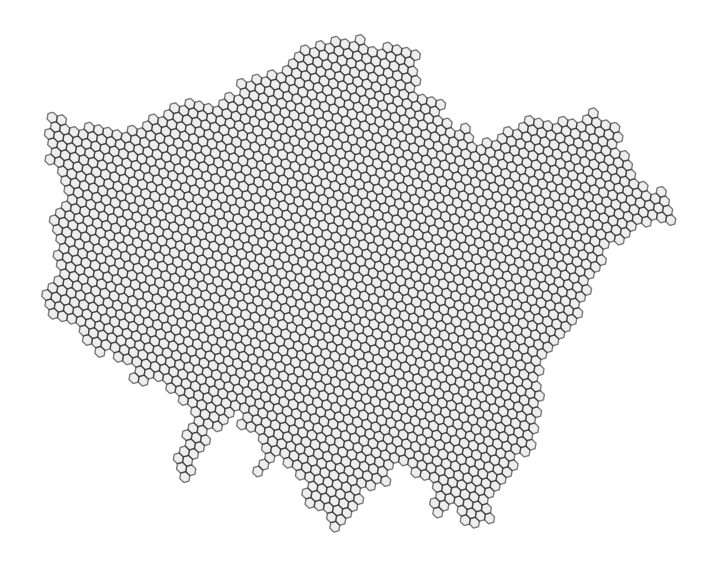

In [54]:
#Get all polygons that intersect our area of interest
hexs = h3.polyfill(london_all["geometry"].iloc[0].__geo_interface__, 8, geo_json_conformant = True)

#Set up a simple lambda function that makes the geo_boundary call from a hex id
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

#Create a geodataframe and populate the geometrie field with the result of the polygonise function with the hexs variable for input
all_polys = gpd.GeoSeries(list(map(polygonise, hexs)), index=hexs, crs="EPSG:4326")

#Plot to see how it looks
ax = all_polys.plot(alpha=0.5, color="#DEDEDE", edgecolor="black", figsize=(9, 9))
ax.axis("off")
plt.show()

In [47]:
# convert to geodataframe to join with points data later
gdf_poly = gpd.GeoDataFrame(crs = 'EPSG:4326', geometry=all_polys)
gdf_poly = gdf_poly.reset_index().rename(columns={"index": "name"})
gdf_poly.head()

,name,geometry
0,88194e6083fffff,"POLYGON ((0.29419 51.54412, 0.28749 51.54296, ..."
1,88195daee9fffff,"POLYGON ((-0.34598 51.58411, -0.35270 51.58291..."
2,88194ac15bfffff,"POLYGON ((-0.16880 51.34311, -0.17549 51.34190..."
3,88194ad945fffff,"POLYGON ((-0.35914 51.48797, -0.36586 51.48676..."
4,88194ad2d1fffff,"POLYGON ((0.07045 51.44964, 0.06376 51.44846, ..."


In [ ]:
# save as geojson to use at later point

